In [1]:
from itertools import repeat
from ast import literal_eval
from pathlib import Path
import json
import pandas as pd

In [2]:
import gzip
import pickle
from wyckoff_transformer.evaluation import StatisticalEvaluator
with gzip.open(Path("cache", "mp_20_biternary", "data.pkl.gz"), "rb") as f:
    datasets_pd = pickle.load(f)
evaluator = StatisticalEvaluator(datasets_pd["test"], pd.concat([datasets_pd["train"], datasets_pd["val"]], axis=0))

In [3]:
GENERATED_PATH = Path("generated")
wycryst_data_raw = pd.read_csv(GENERATED_PATH / "WyCryst_mp_20_biternary.csv", index_col=0,
                            converters=dict(zip(
                                ("reconstructed_ratio1", "reconstructed_wyckoff", "str_wyckoff", "ter_sys"),
                                repeat(literal_eval, 4)
                            )))

In [4]:
from wyckoff_transformer.evaluation import wycryst_to_pyxtal_dict

def check_novelty_wycryst(record):
    pyxtal_dict = wycryst_to_pyxtal_dict(record)
    if pyxtal_dict is None:
        return False
    return evaluator.generated_to_fingerprint(pyxtal_dict) not in evaluator.train_fingerprints
novel_wycryst_pd = wycryst_data_raw[wycryst_data_raw.apply(check_novelty_wycryst, axis=1)]
novel_wycryst_pd.to_csv(GENERATED_PATH / "WyCryst_novel_mp_20_biternary.csv.gz", compression={'method': 'gzip', 'mtime': 0})

In [5]:
generated_wycryst = wycryst_data_raw.apply(wycryst_to_pyxtal_dict, axis=1).dropna()

In [6]:
with gzip.open(GENERATED_PATH / "WyckoffTransformer_mp_20_biternary.json.gz", "rt") as f:
    generated_wyckoff_transformer = json.load(f)

In [7]:
import pickle
from wyckoff_transformer.evaluation import (
    timed_smact_validity_from_record, StatisticalEvaluator,
    smac_validity_from_counter, generated_to_fingerprint)

print("Test novelty: ",evaluator.get_test_novelty())
print("WyCryst novelty: ", evaluator.count_novel(generated_wycryst))
print("WyckoffTransformer novelty: ", evaluator.count_novel(generated_wyckoff_transformer))
novel_wycryst = evaluator.get_novel(generated_wycryst)
novel_wyckoff_transformer = evaluator.get_novel(generated_wyckoff_transformer)

Test novelty:  0.9598201742062377
WyCryst novelty:  0.29177947812438687
WyckoffTransformer novelty:  0.8648


In [8]:
from utils import dump_json_to_gz
dump_json_to_gz(GENERATED_PATH / "WyckoffTransformer_novel_mp_20_biternary.json.gz", novel_wyckoff_transformer)

In [9]:
novel_evaluator = StatisticalEvaluator(evaluator.get_novel_dataframe(datasets_pd["test"]),
                                       pd.concat([datasets_pd["train"], datasets_pd["val"]], axis=0))

In [10]:
smact_validity_test = sum(map(smac_validity_from_counter, datasets_pd["test"]["composition"]))/len(datasets_pd["test"])
print("Test SMAC-T: ", smact_validity_test)

datasets = {
    "WyCryst": (generated_wycryst, evaluator),
    "WyckoffTransformer": (generated_wyckoff_transformer, evaluator),
    "WyCryst Novel": (novel_wycryst, novel_evaluator),
    "WyckoffTransformer Novel": (novel_wyckoff_transformer, novel_evaluator)}
for name, (dataset, this_evaluator) in datasets.items():
    print(name)
    smact_validity = sum(map(timed_smact_validity_from_record, dataset))/len(dataset)
    print("SMAC-T validity: ", smact_validity)
    print("Num sites KS: ", this_evaluator.get_num_sites_ks(dataset))
    print("Num elements KS :", this_evaluator.get_num_elements_ks(dataset))
    print("DoF KS: ", this_evaluator.get_dof_ks(dataset))
    sg_chi2 = this_evaluator.get_sg_chi2(dataset, sample_size="test")
    print(f"SG chi2: statistic={sg_chi2.statistic}, pvalue={sg_chi2.pvalue}")

Test SMAC-T:  0.8981455465018263
WyCryst
SMAC-T validity:  0.8373454973513832
Num sites KS:  KstestResult(statistic=0.03975535196011648, pvalue=1.4236638119437514e-09, statistic_location=4, statistic_sign=1)
Num elements KS : KstestResult(statistic=0.03838199508352241, pvalue=5.947351369026711e-09, statistic_location=2, statistic_sign=-1)
DoF KS:  KstestResult(statistic=0.04117394256950424, pvalue=3.0839361418463316e-10, statistic_location=7, statistic_sign=1)
SG chi2: statistic=703.5853771023179, pvalue=1.6072519094623623e-73
WyckoffTransformer


SMAC-T validity:  0.8063
Num sites KS:  KstestResult(statistic=0.02380339983141332, pvalue=0.017604870205337915, statistic_location=4, statistic_sign=1)
Num elements KS : KstestResult(statistic=0.0257, pvalue=0.008049610835145911, statistic_location=3, statistic_sign=1)
DoF KS:  KstestResult(statistic=0.0188548468670975, pvalue=0.10231187840614872, statistic_location=2, statistic_sign=1)
SG chi2: statistic=152.11975499959556, pvalue=0.3691994206142184
WyCryst Novel
SMAC-T validity:  0.7335597095212479
Num sites KS:  KstestResult(statistic=0.2796992422819146, pvalue=0.0, statistic_location=3, statistic_sign=1)
Num elements KS : KstestResult(statistic=0.004451737339108447, pvalue=0.9998335648003727, statistic_location=2, statistic_sign=1)
DoF KS:  KstestResult(statistic=0.20917388936306303, pvalue=6.022183272547049e-221, statistic_location=2, statistic_sign=1)
SG chi2: statistic=2030.4292390338676, pvalue=0.0
WyckoffTransformer Novel


SMAC-T validity:  0.7972941720629048
Num sites KS:  KstestResult(statistic=0.039500254595520624, pvalue=9.854143711269751e-06, statistic_location=4, statistic_sign=1)
Num elements KS : KstestResult(statistic=0.02971785383903793, pvalue=0.0019699337641728505, statistic_location=3, statistic_sign=1)
DoF KS:  KstestResult(statistic=0.042402857967930065, pvalue=1.5342722610037222e-06, statistic_location=2, statistic_sign=1)
SG chi2: statistic=215.41483375782673, pvalue=0.00020286983495509275


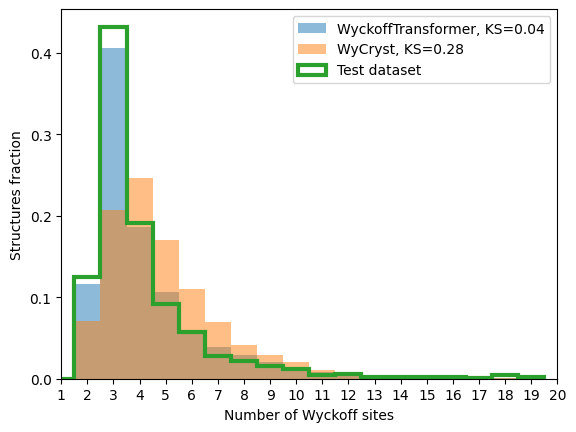

In [71]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
num_sites_wt_ks, num_sites_wt = novel_evaluator.get_num_sites_ks(novel_wyckoff_transformer, return_counts=True)
num_sites_wc_ks, num_sites_wc = novel_evaluator.get_num_sites_ks(novel_wycryst, return_counts=True)
num_sites_test = novel_evaluator.test_dataset['site_symmetries'].map(len)
bins = list(range(1, 21))
ax.hist(num_sites_wt, bins=bins, density=True, alpha=0.5, label=f"WyckoffTransformer, KS={num_sites_wt_ks.statistic:.2f}",
    align='left', histtype='stepfilled')
ax.hist(num_sites_wc, bins=bins, density=True, alpha=0.5, label=f"WyCryst, KS={num_sites_wc_ks.statistic:.2f}", align='left')
ax.hist(num_sites_test, bins=bins, histtype='step', lw=3, density=True, label="Test dataset", align='left')
ax.legend()
ax.set_xlabel("Number of Wyckoff sites")
ax.set_ylabel("Structures fraction")
ax.set_xlim(1, 20)
ax.set_xticks(bins);

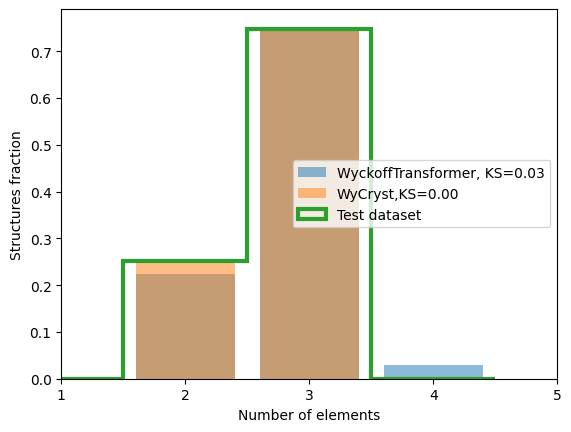

In [12]:
import numpy as np
fig, ax = plt.subplots()
num_elements_wt_ks, num_elements_wt = novel_evaluator.get_num_elements_ks(novel_wyckoff_transformer, return_counts=True)
num_elements_wc_ks, num_elements_wc = novel_evaluator.get_num_elements_ks(novel_wycryst, return_counts=True)
num_elements_test = novel_evaluator.test_dataset['composition'].map(len)
bins = list(range(1, 6))
ax.hist(num_elements_wt, bins=bins, density=True, alpha=0.5,
    label=f"WyckoffTransformer, KS={num_elements_wt_ks.statistic:.2f}", histtype='bar', rwidth=0.8, align='left')
ax.hist(num_elements_wc, bins=bins, density=True, alpha=0.5,
    label=f"WyCryst,KS={num_elements_wc_ks.statistic:.2f}", histtype='bar', rwidth=0.8, align='left')
ax.hist(num_elements_test, bins=bins, histtype='step', lw=3, density=True, label="Test dataset",
    align='left')
ax.legend()
ax.set_xlabel("Number of elements")
ax.set_ylabel("Structures fraction")
ax.set_xlim(1, 4.5)
ax.set_xticks(range(1, 6));

In [16]:
elements_wt_chi2, elements_wt, elements_test = \
    novel_evaluator.get_elements_chi2(novel_wyckoff_transformer, sample_size="test", return_counts=True)

Ga    2035
Te    1710
Cu    2338
Ni    2781
Ho    1049
      ... 
W      391
Sr     823
Pa     162
Np      72
He      12
Length: 85, dtype: int64
Ge    2434
N     1686
Ca    1108
Co    2795
Al    2942
      ... 
Dy     746
Os     425
Pu     116
Xe       6
Kr       2
Length: 86, dtype: int64


In [42]:
elements_wc_chi2, elements_wc, _ = \
    novel_evaluator.get_elements_chi2(novel_wycryst, sample_size="test", return_counts=True)

Ga    2035
Te    1710
Cu    2338
Ni    2781
Ho    1049
      ... 
W      391
Sr     823
Pa     162
Np      72
He      12
Length: 85, dtype: int64
Na     1320
Bi     1256
O     26640
In     1769
S      5322
      ...  
Yb      673
Tc      127
Pa       44
Kr        3
Ac       82
Length: 85, dtype: int64


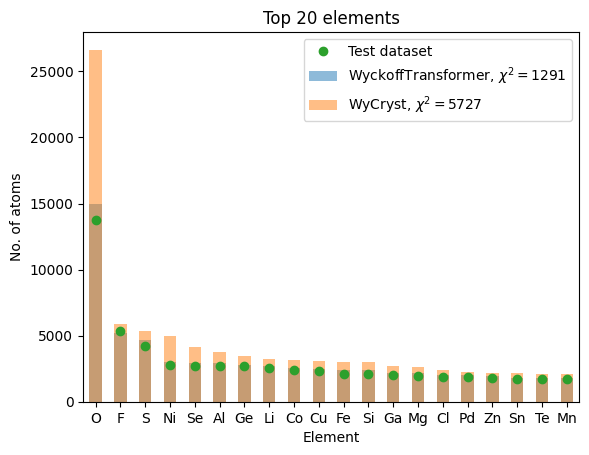

In [70]:
fig, ax = plt.subplots()
elements_wt.sort_values(inplace=True, ascending=False)
n_elements_to_plot = 20
elements_wt.iloc[:n_elements_to_plot].plot(kind='bar', ax=ax, alpha=0.5,
    label=f"WyckoffTransformer, $\\chi^2={elements_wt_chi2.statistic:.0f}$")
elements_wc.sort_values(ascending=False).iloc[:n_elements_to_plot].plot(kind='bar', ax=ax, alpha=0.5,
    label=f"WyCryst, $\\chi^2={elements_wc_chi2.statistic:.0f}$", color='tab:orange')
elements_test.sort_values(ascending=False).iloc[:n_elements_to_plot].plot(kind='line',
ax=ax, label="Test dataset", style='o', color='tab:green')
ax.set_xlabel("Element")
ax.set_ylabel("No. of atoms")
ax.set_title(f"Top {n_elements_to_plot} elements")
ax.legend();

In [14]:
train_sg = set(datasets_pd["train"].spacegroup_number)
train_sg.update(datasets_pd["val"].spacegroup_number)
test_sg = frozenset(datasets_pd["test"].spacegroup_number)

In [15]:
len(train_sg), len(test_sg), len(train_sg & test_sg)

(169, 148, 145)